# Set Parameter
- Attention = True
- Teacher Forcing Ratio = 0.5
- Dropout = 0.2
- Layer = 4
- Batch size = 128
- Learning rate = 0.001
- Hidden unit = 300
- Epochs = 20
- Data = ids

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys
import json
import numpy as np

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from models.trainer import Trainer
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from dataset import fields

import matplotlib.pyplot as plt

# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentence_accuracy = []
f1_score = []
best_f1_score = []
rnn = "lstm"
data_name = "ids"
pretrained_dir_name = None
iterator = list(range(1,6,1))
epochs = 20

train_path = "data/network_inputs/iitk-"+data_name+"-1189"+"/data_train.txt"
dev_path = "data/network_inputs/iitk-"+data_name+"-1189"+"/data_val.txt"

config_path = "models/config.json"

# Prepare dataset

In [ ]:
for i in iterator:
        print("rnn : %s" % rnn)
        max_len = 450
        src = fields.SourceField()
        srcp = fields.SourceField()
        tgt = fields.TargetField()
        tgtp = fields.TargetField()
        def len_filter(example):
            return len(example.src) <= max_len and len(example.tgt) <= max_len
        train = torchtext.data.TabularDataset(
            path=train_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        dev = torchtext.data.TabularDataset(
            path=dev_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        src.build_vocab(train)
        tgt.build_vocab(train)
        input_vocab = src.vocab
        output_vocab = tgt.vocab

        print("src vocab size = %d" % (len(src.vocab)))
        print("tat vacab size = %d" % (len(tgt.vocab)))

        weight = torch.ones(len(tgt.vocab))
        pad = tgt.vocab.stoi[tgt.pad_token]
        loss = Perplexity(weight, pad)
        if torch.cuda.is_available():
            loss.cuda()

        optimizer = "Adam"
        seq2seq = None
        config_json = open(config_path).read()
        config = json.loads(config_json)
        config["encoder_max_len"] = 450
        config["decoder_max_len"] = 75
        config["hidden_size"] = 300
        config["rnn_cell"] = rnn
        config["n_layers"] = 4
        config["dropout_p"] = 0.2
        config["embedding_size"] = 50
        config["use_attention"] = True
        config["encoder_position_embedding"] = None
        config["decoder_position_embedding"] = None
        config["use_memory"] = None
        #config["seed"]= 1189
        #config["pos_add"] = "cat"

        print(json.dumps(config, indent=4))

        save_path = (data_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos" if config["encoder_position_embedding"] is not None 
                           or config["decoder_position_embedding"] is not None else "")
                        + ("_encoder_" + config["encoder_position_embedding"]
                           if config["encoder_position_embedding"] is not None else "")
                        + ("_decoder_" + config["decoder_position_embedding"]
                           if config["decoder_position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + ("_pretrained" if pretrained_dir_name is not None else ""))
        print("Save_path : %s" % save_path)
        
        if pretrained_dir_name is not None:
            pretrained_path = ("pretrained_weights/"+ data_name + "_" + pretrained_dir_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos" if config["encoder_position_embedding"] is not None 
                           or config["decoder_position_embedding"] is not None else "")
                        + ("_encoder_" + config["encoder_position_embedding"]
                           if config["encoder_position_embedding"] is not None else "")
                        + ("_decoder_" + config["decoder_position_embedding"]
                           if config["decoder_position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + "_"+rnn+"_"+str(i))
            encoder_pos_weight = np.load(pretrained_path+"/encoder_pos_weight.npy")
            decoder_pos_weight = np.load(pretrained_path+"/decoder_pos_weight.npy")
            seq2seq = Seq2seq(config, vocab_size, vocab_size, sos_id, eos_id,
                              encoder_pos_weight, decoder_pos_weight)
        else :
            seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)
        
        if torch.cuda.is_available():
            seq2seq.cuda()

        for param in seq2seq.parameters():
            param.data.uniform_(-0.08, 0.08)

        # train
        t = Trainer(loss=loss, batch_size=128,
                    learning_rate=0.001,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=config["hidden_size"],
                    path=save_path,
                    file_name=config["rnn_cell"] + "_" + str(i))

        seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                                 num_epochs=epochs, dev_data=dev,
                                                                                 optimizer=optimizer,
                                                                                 teacher_forcing_ratio=0.5)

        character_accuracy.append(character_accuracy_list)
        sentence_accuracy.append(sentence_accuracy_list)
        f1_score.append(f1_score_list)
        best_f1_score.append(max(f1_score_list))

rnn : lstm
src vocab size = 120
tat vacab size = 56


/home/bshong/hyeontae/ht_venv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
2020-05-27 16:33:27,751 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


{
    "encoder_max_len": 450,
    "decoder_max_len": 75,
    "embedding_size": 50,
    "hidden_size": 300,
    "input_dropout_p": 0,
    "dropout_p": 0.2,
    "n_layers": 4,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": true,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": false,
    "encoder_position_embedding": null,
    "decoder_position_embedding": null,
    "pos_add": "add",
    "use_memory": null,
    "memory_dim": 5,
    "seed": null
}
Save_path : ids_att_emb50_hidden300


/home/bshong/hyeontae/ht_venv/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2020-05-27 16:37:09,900 INFO   Finished epoch 1: Train loss: 2.3757, Dev loss: 2.1370, Accuracy(character): 0.7381, Accuracy(sentence): 0.2057, F1 Score: 0.7265
2020-05-27 16:40:53,408 INFO   Finished epoch 2: Train loss: 1.8326, Dev loss: 1.8609, Accuracy(character): 0.7840, Accuracy(sentence): 0.2574, F1 Score: 0.7692
2020-05-27 16:44:37,637 INFO   Finished epoch 3: Train loss: 1.6320, Dev loss: 1.6786, Accuracy(character): 0.8096, Accuracy(sentence): 0.3304, F1 Score: 0.7948
2020-05-27 16:48:20,830 INFO   Finished epoch 4: Train loss: 1.4880, Dev loss: 1.5116, Accuracy(character): 0.8491, Accuracy(sentence): 0.4279, F1 Score: 0.8373
2020-05-27 16:52:04,199 INFO   Finished epoch 5: Train loss: 1.4013, Dev loss: 1.4589, Accuracy(character): 0.8645, Accur

rnn : lstm


2020-05-27 17:53:01,615 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


src vocab size = 120
tat vacab size = 56
{
    "encoder_max_len": 450,
    "decoder_max_len": 75,
    "embedding_size": 50,
    "hidden_size": 300,
    "input_dropout_p": 0,
    "dropout_p": 0.2,
    "n_layers": 4,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": true,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": false,
    "encoder_position_embedding": null,
    "decoder_position_embedding": null,
    "pos_add": "add",
    "use_memory": null,
    "memory_dim": 5,
    "seed": null
}
Save_path : ids_att_emb50_hidden300


2020-05-27 17:56:48,927 INFO   Finished epoch 1: Train loss: 2.4683, Dev loss: 2.4584, Accuracy(character): 0.7258, Accuracy(sentence): 0.2046, F1 Score: 0.7124
2020-05-27 18:00:32,619 INFO   Finished epoch 2: Train loss: 2.3451, Dev loss: 2.8444, Accuracy(character): 0.6760, Accuracy(sentence): 0.1194, F1 Score: 0.6599
2020-05-27 18:04:16,440 INFO   Finished epoch 3: Train loss: 2.0642, Dev loss: 2.0943, Accuracy(character): 0.7443, Accuracy(sentence): 0.2178, F1 Score: 0.7344


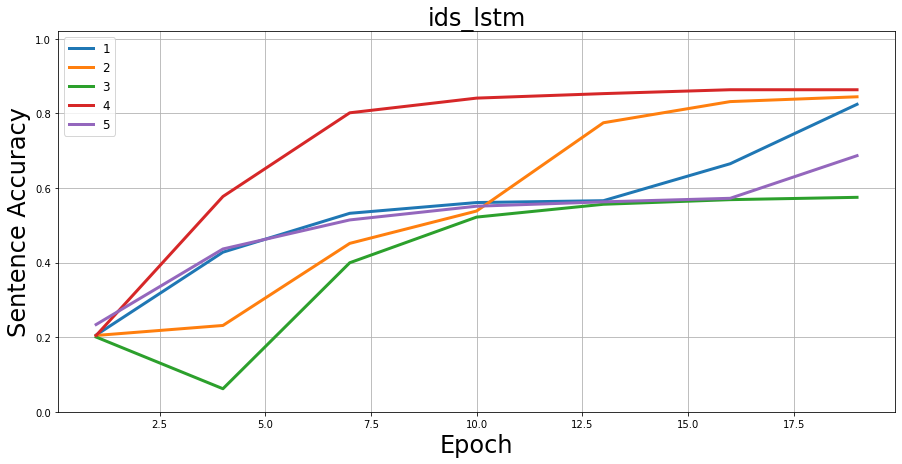

In [11]:
plt.figure(figsize=(15,7))
for j in range(len(sentence_accuracy)):
    plt.plot(list(range(1, len(sentence_accuracy[j])+1, 1))[::3], sentence_accuracy[j][::3], '-', LineWidth=3, label=str(j+1))

plt.legend(loc="best", fontsize=12)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentence Accuracy', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

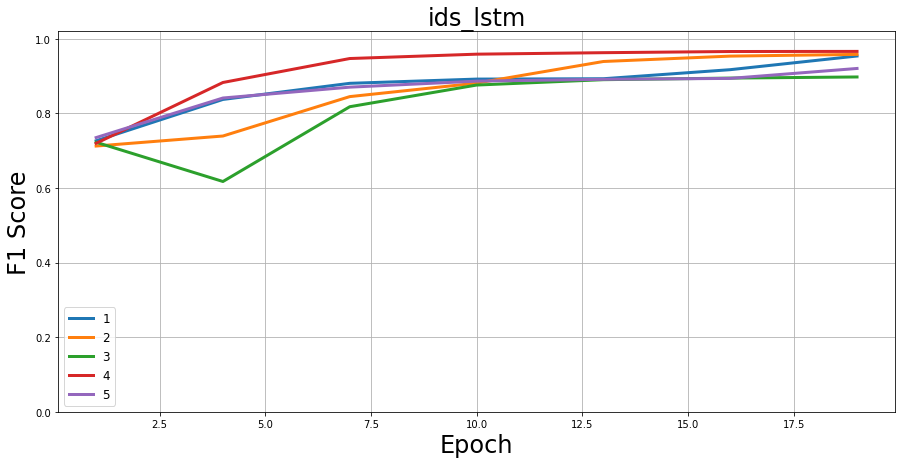

In [12]:
plt.figure(figsize=(15,7))
for j in range(len(f1_score)):
    plt.plot(list(range(1, len(f1_score[j])+1, 1))[::3], f1_score[j][::3], '-', LineWidth=3, label=str(j+1))

plt.legend(loc="best", fontsize=12)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

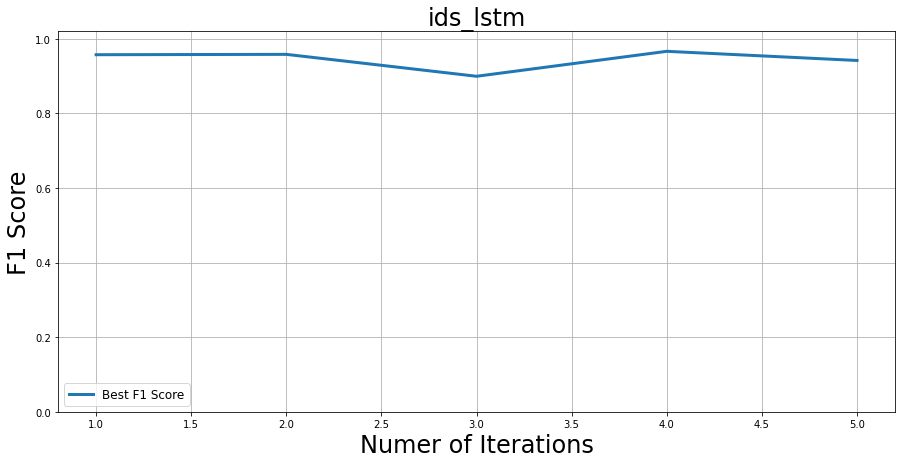

In [13]:
plt.figure(figsize=(15,7))
plt.plot(list(range(1, len(best_f1_score)+1)), best_f1_score, '-', LineWidth=3, label="Best F1 Score")

plt.legend(loc="best", fontsize=12)
plt.xlabel('Numer of Iterations', fontsize=24)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

In [14]:
print(f1_score)

[[0.7264722463333662, 0.76919870730013, 0.7947973407809531, 0.8372913209020794, 0.8541879669681479, 0.8695072351826597, 0.880487900941324, 0.8862484022801205, 0.8902151292227277, 0.891841307180847, 0.8936811615258192, 0.895605594202196, 0.892795727572176, 0.8958854773542365, 0.8981609793586726, 0.9170747959353657, 0.924658260040267, 0.9524179051995648, 0.9537277945207554, 0.9571900806432083], [0.7123811461431213, 0.659943854306684, 0.7343911632165321, 0.7392540007806402, 0.7901331833804943, 0.8189653864707185, 0.8448719001602958, 0.8626280868438616, 0.8738753733624255, 0.8809872145537816, 0.8967607352304483, 0.9156222172414419, 0.9390260512671504, 0.949667202411761, 0.9507258464179086, 0.9534285740245503, 0.9548357429609527, 0.9561689738019712, 0.9580334061835948, 0.9581358705532999], [0.7225216503243859, 0.7169231966337363, 0.6596688200787109, 0.6173317191428769, 0.7139659052818081, 0.774592409815468, 0.8177773163007596, 0.8483472086560239, 0.8641110111594661, 0.8758559799510305, 0.88

In [15]:
print(best_f1_score)

[0.9571900806432083, 0.9581358705532999, 0.8994067094448712, 0.9662892769439002, 0.941765186103468]


In [16]:
print(sum(best_f1_score, 0.0)/len(best_f1_score))

0.9445574247377495
